In [373]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
import scipy as sp
from torch.autograd import Variable

In [374]:
# Real data distribution will be a normal distribution
class RealDistribution:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    def sample(self, num_samples):
        samples = np.random.normal(self.mu, self.sigma, num_samples)
        samples.sort()
        
        return samples

# Noise data distribution as inputs for the generator
class NoiseDistribution:
    def __init__(self, data_range):
        self.data_range = data_range

    def sample(self, num_samples):
        # Random floats with uniform dist. in the interval [0.0, 0.05)
        offset = np.random.random(num_samples)*0.05
        samples = np.linspace(-self.data_range, self.data_range, num_samples) + offset
        
        return samples

#### Generator Code

In [375]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(input_dim , hidden_dim , bias = True)
        self.layer2 = nn.Linear(hidden_dim , output_dim , bias = True)
        self.relu = nn.ReLU()

        nn.init.kaiming_normal(self.layer1.weight)
        nn.init.constant_(self.layer1.bias, 0.0)

        nn.init.kaiming_normal_(self.layer2.weight)
        nn.init.constant_(self.layer2.bias, 0.0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

#### Discriminator Code

In [376]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(input_dim , hidden_dim , bias = True)
        self.layer2 = nn.Linear(hidden_dim , output_dim , bias = True)
        self.relu = nn.ReLU()

        nn.init.kaiming_normal_(self.layer1.weight)
        nn.init.constant_(self.layer1.bias, 0.0)

        nn.init.kaiming_normal_(self.layer2.weight)
        nn.init.constant_(self.layer2.bias, 0.0)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return torch.sigmoid(x)

In [377]:
# generating samples for testing

class Testing:
    def __init__(self, discriminator, generator, realD, data_range, batch_size, num_samples, num_bins):
        self.D = discriminator
        self.G = generator
        self.realD = realD
        self.bs = batch_size
        self.num_samples = num_samples
        self.num_bins = num_bins
        self.s = np.linspace(-data_range, data_range, num_samples)

        # random points to generate samples from the generator
        self.xs = np.linspace(-data_range, data_range, num_samples)
        self.bins = np.linspace(-data_range, data_range, num_bins)

    
    # generating the real samples, which are sampled from N(mu,sigma)
    def real_distribution(self):
        d = self.realD.sample(self.num_samples)

        # generating the distribution
        p_data, _ = np.histogram(d, self.bins, density=True)
        return p_data

    # generating the data from the generator, which it assumes to be from the same distribution
    def gen_distribution(self):
        zs = self.xs

        # to store generator output
        g = np.zeros((self.num_samples, 1))

        # passing the random points through generator and obtaining its outputs
        for i in range(self.num_samples // self.bs):
            z_ = zs[self.bs*i:self.bs*(i+1)]
            z_ = Variable(torch.FloatTensor(np.reshape(z_, [self.bs, 1])))
            g[self.bs*i:self.bs*(i+1)] = self.G(z_).detach().numpy()

        # generating the distribution
        p_gen, _ = np.histogram(g, self.bins, density=True)
        
        return p_gen

#### Pretraining the Discriminator

In [378]:
# Hyper-parameters
mu = 0.0
sigma = 1.0
data_range = 5
batch_size = 10

input_dim = 1
hidden_dim = 32
output_dim = 1
num_epochs = 2000
num_epochs_pre = 2000
learning_rate = 0.001

/var/folders/x0/r7576wrd5w3dfxhxvxn3v81w0000gn/T/ipykernel_90326/3878161273.py:8: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.layer1.weight)


Epoch : 0 , Loss : 0.5519145727157593
Epoch : 100 , Loss : 0.5526764392852783
Epoch : 200 , Loss : 0.5094643235206604
Epoch : 300 , Loss : 0.5291358828544617
Epoch : 400 , Loss : 0.5000002384185791
Epoch : 500 , Loss : 0.5198829770088196
Epoch : 600 , Loss : 0.45704615116119385
Epoch : 700 , Loss : 0.44168099761009216
Epoch : 800 , Loss : 0.4526866674423218
Epoch : 900 , Loss : 0.5393627882003784
Epoch : 1000 , Loss : 0.43278366327285767
Epoch : 1100 , Loss : 0.4918922781944275
Epoch : 1200 , Loss : 0.49358612298965454
Epoch : 1300 , Loss : 0.46241623163223267
Epoch : 1400 , Loss : 0.46309930086135864
Epoch : 1500 , Loss : 0.4064655303955078
Epoch : 1600 , Loss : 0.39306554198265076
Epoch : 1700 , Loss : 0.45467543601989746
Epoch : 1800 , Loss : 0.4628587067127228
Epoch : 1900 , Loss : 0.4110700190067291


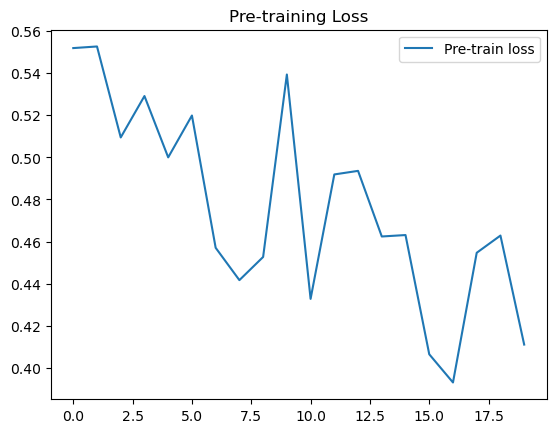

In [379]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal

# Create models
G = Generator(input_dim, hidden_dim, output_dim)
D = Discriminator(input_dim, hidden_dim, output_dim)

# Loss function
bceloss = torch.nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)

num_samples_pre = 1000
num_bins_pre = 100 # number of equal-width bins in a histogram
D_pre_losses = []
for epoch in range(num_epochs_pre):
    # Generate samples
    real = realData.sample(num_samples_pre)
    
    # making the histogram from the data
    histc, edges = np.histogram(real, num_bins_pre, density=True)

    # Estimate pdf
    max_histc = np.max(histc)
    min_histc = np.min(histc)
    y_ = (histc - min_histc) / (max_histc - min_histc)  # normalize y_ to range [0,1]
    x_ = edges[1:]
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [num_bins_pre, input_dim])))
    y_ = Variable(torch.FloatTensor(np.reshape(y_, [num_bins_pre, output_dim])))


    # Train D model
    optimizer.zero_grad()
    D_pre_decision = D(x_)
    
    # Updating the weights
    D_pre_loss = bceloss(D_pre_decision, y_)
    D_pre_loss.backward()
    optimizer.step()

    # Save loss values for plot

    if epoch % 100 == 0:
        print("Epoch : {} , Loss : {}".format(epoch, D_pre_loss.item()))
        D_pre_losses.append(D_pre_loss.item())
    #print(epoch, D_pre_loss.item())

# Plot loss
fig, ax = plt.subplots()
losses = np.array(D_pre_losses)
plt.plot(losses, label='Pre-train loss')
plt.title("Pre-training Loss")
plt.legend()
plt.show()

In [380]:
# Samples
realData = RealDistribution(mu, sigma)     # via np.random.normal
noiseData = NoiseDistribution(data_range)  # unfiorm plus some variations

# Test sample after pre-training (to be drawn later)
num_samples = 10000
num_bins = 50
sample = Testing(D, G, realData, data_range, batch_size, num_samples, num_bins)

#### Training the GAN

epoch : 0, D loss : 1.07810640335083, G loss : 6.4568376541137695
epoch : 10000, D loss : 1.350010633468628, G loss : 0.8078070878982544
epoch : 20000, D loss : 1.3578596115112305, G loss : 0.7302354574203491
epoch : 30000, D loss : 1.4345622062683105, G loss : 0.5846748352050781
epoch : 40000, D loss : 1.3820784091949463, G loss : 0.6953020095825195
epoch : 50000, D loss : 1.414482593536377, G loss : 0.6778020858764648
epoch : 60000, D loss : 1.3877182006835938, G loss : 0.7120246291160583
epoch : 70000, D loss : 1.3723936080932617, G loss : 0.6971393823623657
epoch : 80000, D loss : 1.3800396919250488, G loss : 0.7052795886993408
epoch : 99999, D loss : 1.3787637948989868, G loss : 0.6942406296730042


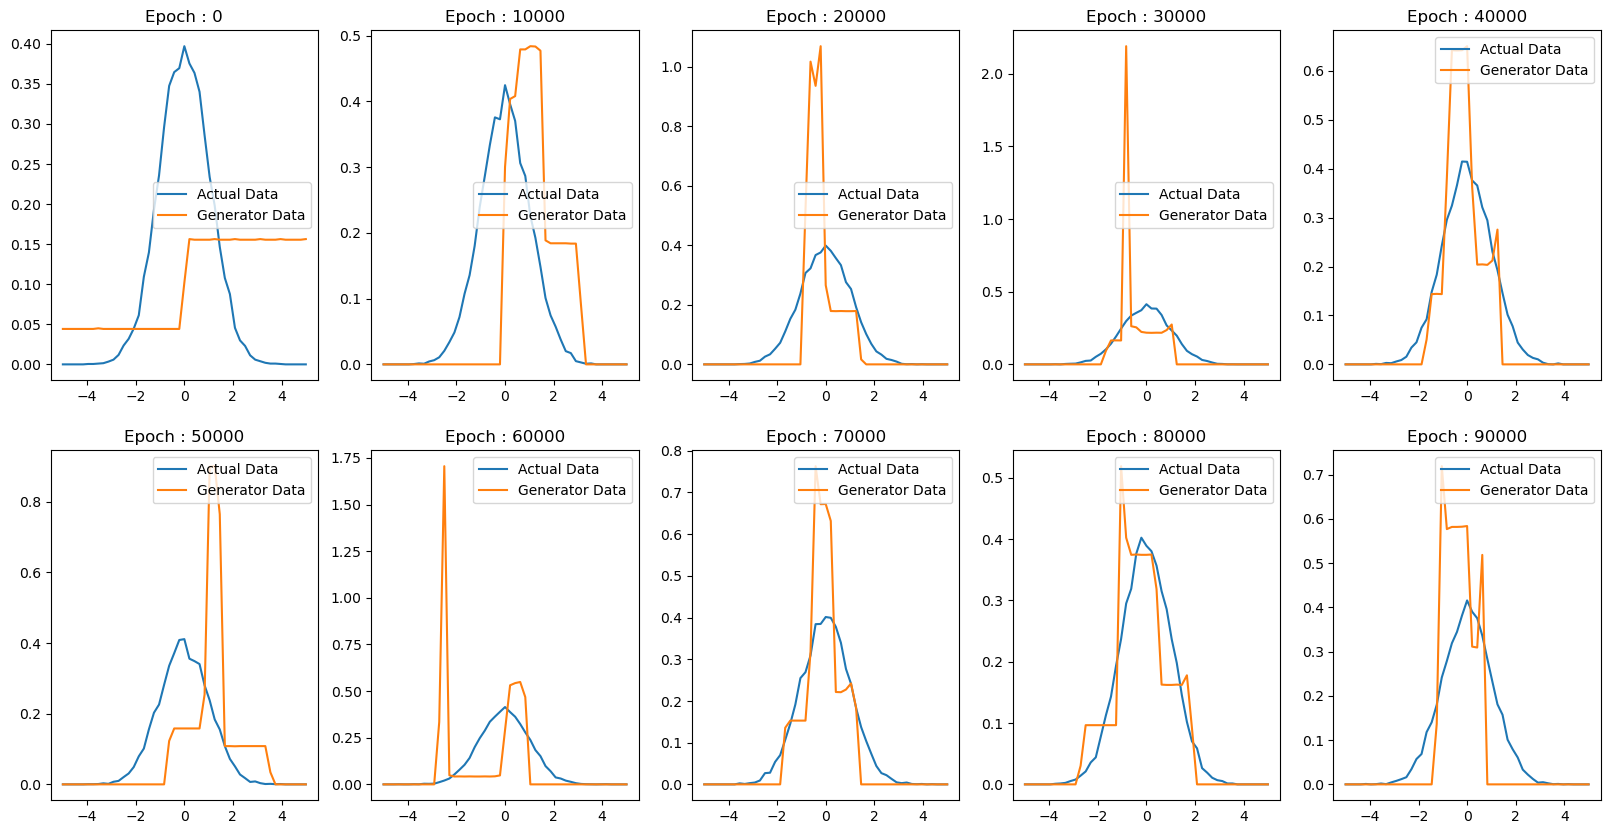

In [381]:
Actual_data = []
Generator_Data = []
# np.random.seed(134)
# setting the optimizers
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

# Loss function
bceloss = torch.nn.BCELoss()

D_losses = []
G_losses = []
num_epochs = 100000

for epoch in range(num_epochs):
    # Generate samples
    x_ = realData.sample(batch_size)
    x_ = Variable(torch.FloatTensor(np.reshape(x_, [batch_size, input_dim])))
    y_real_ = Variable(torch.ones([batch_size, output_dim]))
    y_fake_ = Variable(torch.zeros([batch_size, output_dim]))

    # Train discriminator with real data
    D_real_decision = D(x_)
    D_real_loss = bceloss(D_real_decision, y_real_)

    # Train discriminator with fake data
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    
    # Generator wishes to fool the discriminator
    z_ = G(z_)

    # Passing the fake data through the discriminator
    D_fake_decision = D(z_)
    D_fake_loss = bceloss(D_fake_decision, y_fake_)

    # total discriminator loss will be the sum of the two
    D_loss = D_real_loss + D_fake_loss
    
    # Back propagation
    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()

    # Train generator by seeing how well it can fool the discriminator
    z_ = noiseData.sample(batch_size)
    z_ = Variable(torch.FloatTensor(np.reshape(z_, [batch_size, input_dim])))
    z_ = G(z_)

    D_fake_decision = D(z_)
    G_loss = bceloss(D_fake_decision, y_real_) # note that we put y_real_ here

    # Back propagation
    G.zero_grad()
    G_loss.backward()
    G_optimizer.step()


    if (epoch %10000 == 0  and epoch != num_epochs - 10000) or epoch == num_epochs - 1 :
        print('epoch : {}, D loss : {}, G loss : {}'.format(epoch, D_loss.item(), G_loss.item()))
        # Test sample after GAN-training
        sample = Testing(D, G, realData, data_range, batch_size, num_samples, num_bins)
        # db_trained = sample.decision_boundary()
        p_data = torch.tensor(sample.real_distribution())
        p_gen = torch.tensor(sample.gen_distribution())
        Actual_data.append(p_data)
        Generator_Data.append(p_gen)

p_x = np.linspace(-data_range, data_range, len(p_data))

plt.figure(figsize = (20 , 10))
for i in range(10):
    plt.subplot(2 , 5 , i+1)
    plt.plot(p_x , Actual_data[i].detach().numpy() , label = 'Actual Data')
    plt.plot(p_x , Generator_Data[i].detach().numpy() , label = 'Generator Data')
    plt.title('Epoch : {}'.format(i*10000))
    plt.legend()

plt.show()


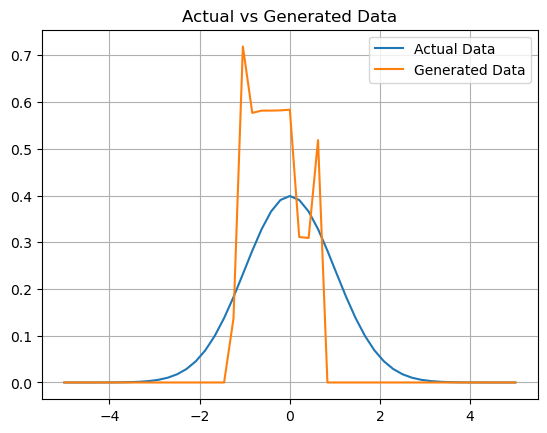

In [382]:
generated_data = Generator_Data[-1].detach().numpy()
plt.grid()
plt.plot(p_x , sp.stats.norm(mu , sigma).pdf(p_x) , label = 'Actual Data')
plt.title("Actual vs Generated Data")
plt.plot(p_x , generated_data , label = 'Generated Data')
plt.legend()
plt.show()

In [383]:
sp.stats.shapiro(generated_data)

ShapiroResult(statistic=0.5134706497192383, pvalue=1.633582678850498e-11)

In [384]:
sp.stats.kstest(generated_data,sp.stats.norm.cdf)

KstestResult(statistic=0.5, pvalue=7.480423059358613e-12)